In [ ]:
!pip install matplotlib --upgrade

     |████████████████████████████████| 10.3 MB 21.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
import sklearn
import pandas
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate,GridSearchCV,ParameterGrid
from sklearn.model_selection import KFold,RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#for auc stuff
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import matplotlib                # Matplotlib is the plotting package that we'll use throughout the lab
import matplotlib.pyplot as plt
import seaborn as sns            # Seaborn is a Python data visualization library based on matplotlib

import numpy as np               # Numpy is a package for scientific computing. We'll use it for some of it's math functions

import graphviz                  # graphviz is a package that helps visualize decision trees

In [ ]:
#load and mount drive 
from google.colab import drive, output

drive.mount('/content/gdrive', force_remount = True)
#for this move the csv into your gdrive


Mounted at /content/gdrive


In [ ]:
output.clear()

In [ ]:
df = pandas.read_csv("/content/gdrive/MyDrive/corona_tested_individuals_ver_006.english.csv", low_memory=False)
df.head()

#we should probably drop test_date. 
#shape of the data is (2742596, 10)

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-11-12,0,0,0,0,0,negative,No,male,Other
1,2020-11-12,0,1,0,0,0,negative,No,male,Other
2,2020-11-12,0,0,0,0,0,negative,Yes,female,Other
3,2020-11-12,0,0,0,0,0,negative,No,male,Other
4,2020-11-12,0,1,0,0,0,negative,No,male,Contact with confirmed


In [ ]:
raw_data = df.sample(10000)
raw_data.reset_index(drop=True, inplace=True)
print(raw_data.shape)

(10000, 10)


In [ ]:
#drop test_date
raw_data.drop(columns=['test_date'], inplace=True)
raw_data.head()


,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,0,0,0,0,0,negative,No,female,Other
1,0,0,0,0,0,negative,NaN,male,Other
2,0,0,0,0,0,negative,No,female,Other
3,0,0,0,0,0,negative,No,female,Other
4,0,0,0,0,0,negative,NaN,female,Other


In [ ]:
#we want to turn: all categorical labels into their own 0 - 1 values, plus corona_results should be 0 for negative, 1 for positive
corona_result_map = {
    'negative': 0,
    'positive': 1
}

age_map = {
    'No': 0,
    'Yes': 1,
    'NaN' : 0
}

gender_map = {
    'female': 0,
    'male': 1
}

raw_data.replace({
    'corona_result': corona_result_map,
    'age_60_and_above': age_map,
    'gender': gender_map    
    }, inplace=True)


#melt test_indication into numerical
raw_data = pandas.concat([raw_data, pandas.get_dummies(raw_data['test_indication'])], axis = 1)
raw_data.drop(columns=['test_indication'], inplace=True)

# Replace any column with the value 'NaN' or 'other' with 0
raw_data['age_60_and_above'] = raw_data['age_60_and_above'].fillna(0)
raw_data['corona_result'] = raw_data['corona_result'].fillna(0)
raw_data['gender'] = raw_data['gender'].fillna(0)
raw_data['corona_result'].replace({'other' : 0}, inplace=True)

raw_data

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,Abroad,Contact with confirmed,Other
0,0,0,0,0,0,0,0.0,0.0,0,0,1
1,0,0,0,0,0,0,0.0,1.0,0,0,1
2,0,0,0,0,0,0,0.0,0.0,0,0,1
3,0,0,0,0,0,0,0.0,0.0,0,0,1
4,0,0,0,0,0,0,0.0,0.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,1.0,1.0,0,0,1
9996,1,1,0,0,0,0,0.0,1.0,1,0,0
9997,0,0,0,0,0,0,0.0,1.0,0,0,1
9998,0,0,0,0,0,0,0.0,0.0,0,0,1


In [ ]:
 # Split the output from the input/features
features_df = raw_data.drop(columns=['corona_result'])
X = features_df 

# Output/Targets
y = raw_data["corona_result"] 

In [ ]:
# Generate train/test split by reserving 10% of data as test set

test_fraction = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_fraction, shuffle=True)

In [ ]:
# Configure Random Forest Classifier Model
Default_model = RandomForestClassifier().fit(X_train,y_train) # fit the decision tree model
print('Model training complete.')

Model training complete.


In [ ]:
Train_predictions = Default_model.predict(X_train)    # Make predictions on training data
Test_predictions = Default_model.predict(X_test)      # Make predictions on testing data

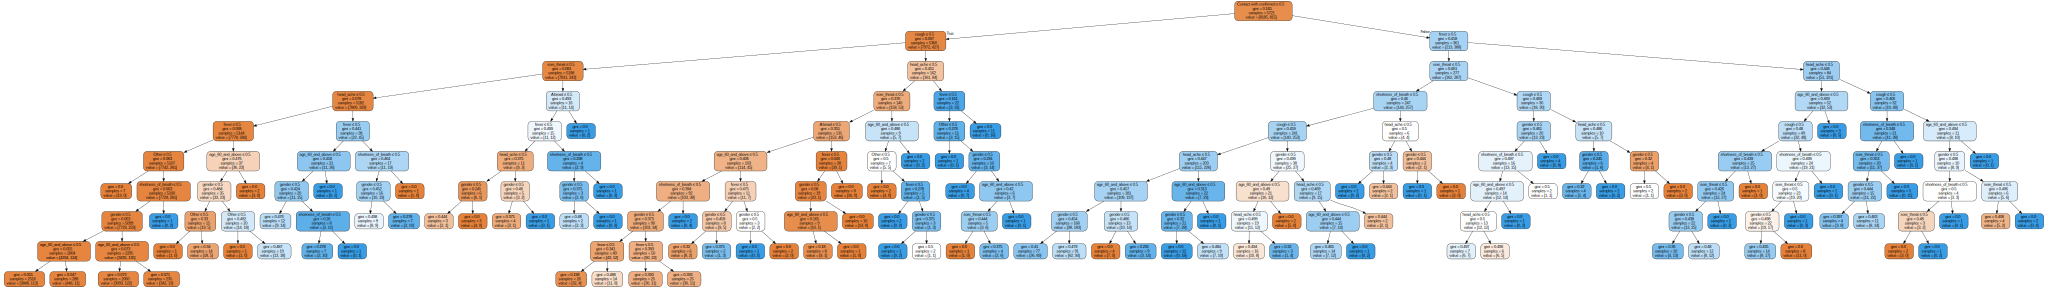

In [ ]:
# generate an image of the default decision tree
dot_data = sklearn.tree.export_graphviz(Default_model.estimators_[0],out_file=None,feature_names=features_df.columns,filled=True,rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
n_classes = y_test.shape[0]
y_score = Default_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

#the reason I don't think we need to binarize the output is that the output is ALREADY binary, i.e. the probability of a label is inversely correlated to the other label,
#so we can get away with this hack :(


# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(1, 1):
#     temp = str(i)
#     fpr[temp], tpr[temp], _ = roc_curve(y_test[:, i], y_score[:, i])
#     roc_auc[temp] = auc(fpr[temp], tpr[temp])

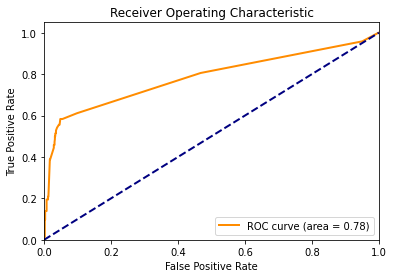

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print('Parameters currently in use:\n')
print(Default_model.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
#implement kfoldcv
# Number of trees in random forest
n_estimators = [1, 5, 10, 50, 100, 200, 400]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [1, 5, 10, 50, 100, 200, 400], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

#best:
# {'bootstrap': True,
#  'max_depth': 110,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 4,
#  'min_samples_split': 5,
#  'n_estimators': 10}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 186 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 10}

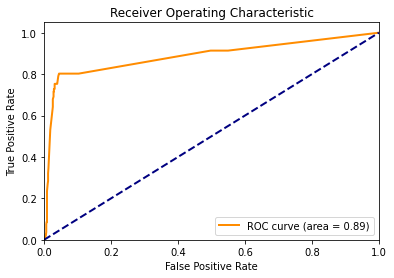

In [ ]:
best_random = rf_random.best_estimator_
n_classes = y_test.shape[0]
y_score_b_random = rf_random.best_estimator_.predict_proba(X_test)
fpr_b_random, tpr_b_random, _ = roc_curve(y_test, y_score_b_random[:, 1])
roc_auc_b_random = auc(fpr_b_random, tpr_b_random)

plt.figure()
lw = 2
plt.plot(fpr_b_random, tpr_b_random, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_b_random)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
gr = RandomForestClassifier()
gr_params = {
    'bootstrap': [True],
    'max_depth': [100, 110, 120],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [4, 5, 6], 
    'n_estimators': [5, 10, 20]
}

gr_random = GridSearchCV(estimator=gr, param_grid = gr_params, cv = 3, n_jobs = -1, verbose = 2)
gr_random.fit(X_train, y_train)
#best:
# {'bootstrap': True,
#  'max_depth': 8,
#  'max_features': 'auto',
#  'min_samples_leaf': 6,
#  'min_samples_split': 3,
#  'n_estimators': 1800}

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:   14.4s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

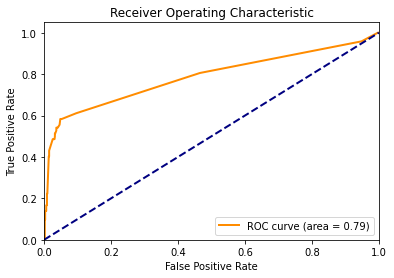

In [ ]:
gr_random.best_params_
best_gr = gr_random.best_estimator_
n_classes = y_test.shape[0]
y_score_gr = gr_random.best_estimator_.predict_proba(X_test)
fpr_gr, tpr_gr, _ = roc_curve(y_test, y_score_gr[:, 1])
roc_auc_gr = auc(fpr_gr, tpr_gr)

plt.figure()
lw = 2
plt.plot(fpr_gr, tpr_gr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_gr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
gr_random.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 10}

In [ ]:
#code for seeing how much ROC improves with # of trees
n_estimators = [1, 5, 10, 20, 50, 100, 200]
roc_values = []

for n_estimator in n_estimators:
    #train model
    m = RandomForestClassifier(n_estimators = n_estimator).fit(X_train,y_train)
    n_classes = y_test.shape[0]
    y_score = m.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
    m_auc = auc(fpr, tpr)

    #append to roc_values
    roc_values.append(m_auc)

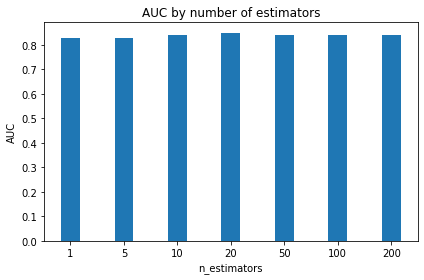

In [ ]:
#create figure
#plt.figure()
#axes.bar(x, y, width=0.5)
#plt.bar(x=[i for i in range(0, 7)], height=roc_values)
#plt.show()

width = 0.35
fig, ax = plt.subplots()
whee = [i for i in range(0, 7)]
rects1 = ax.bar(whee, roc_values, width)

ax.set_ylabel('AUC')
ax.set_xlabel('n_estimators')
ax.set_title('AUC by number of estimators')
ax.set_xticks(whee)
ax.set_xticklabels(list(map(lambda x: str(x), n_estimators)))

fig.tight_layout()

plt.show()


In [ ]:
matplotlib.__version__

'3.4.2'

In [ ]:
roc_values

[0.7606750241080039,
 0.7961234329797494,
 0.8027836708453874,
 0.80175506268081,
 0.7944648023143683,
 0.7954419800707169,
 0.8019607843137254]